# Starter notebook for NIH Chest Xray

## Copy data from GCS (if not so yet)

In [1]:
# user-specific setting
PROJECT = 'mcsds-dlh-free'  # CHANGE: billing project name (since the dataset is user-to-pay)
DATA_FOLDER = '../data/'

In [2]:
# Download images from GCS. Takes a few minutes.
# https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest#gcp_data_access

#!gsutil -u {PROJECT} -m -q cp -r gs://gcs-public-data--healthcare-nih-chest-xray/png/*.png {DATA_FOLDER}

# Download addition labels
# https://pubs.rsna.org/doi/10.1148/radiol.2019191293

#!gsutil -u {PROJECT} -m -q cp -r gs://gcs-public-data--healthcare-nih-chest-xray-labels/* {DATA_FOLDER}

# Code starts here

In [3]:
# import libraries
import pandas as pd
import numpy as np
import random
import os
import torch
from torch.utils.data import Dataset
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer

# check if CUDA is available (GPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cpu


/opt/conda/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370156314/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
# set seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

In [5]:
# explore the dataset
# load train test split
with open('train_val_list.txt') as f: 
    train_val_list = [x.strip() for x in f.readlines()]
with open('test_list.txt') as f:
    test_list = [x.strip() for x in f.readlines()]

# load labels
df_labels = pd.read_csv('Data_Entry_2017_v2020.csv')
print(f"Number of images: {len(df_labels)}")
# split the finding (disease) labels, to a list
df_labels['targets'] = df_labels['Finding Labels'].str.split("|", expand = False)
# look at available labels
labels = set([item for sublist in df_labels['targets'].tolist() for item in sublist])

print(f"Number of labels: {len(labels)}")
print(f"Labels: {labels}")

# one-hot encode labels to columns
mlb = MultiLabelBinarizer(sparse_output=True)

df_labels = df_labels.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(df_labels.pop('targets')),
                index=df_labels.index,
                columns=mlb.classes_))
df_labels[list(labels)]=df_labels[list(labels)].sparse.to_dense()  # for easy .describe()

# show converted data
df_labels[['Finding Labels', *list(labels)]].head(10)

Number of images: 112120
Number of labels: 15
Labels: {'Cardiomegaly', 'Edema', 'Nodule', 'Atelectasis', 'Pleural_Thickening', 'Fibrosis', 'Emphysema', 'Infiltration', 'No Finding', 'Pneumothorax', 'Consolidation', 'Effusion', 'Mass', 'Pneumonia', 'Hernia'}


,Finding Labels,Cardiomegaly,Edema,Nodule,Atelectasis,Pleural_Thickening,Fibrosis,Emphysema,Infiltration,No Finding,Pneumothorax,Consolidation,Effusion,Mass,Pneumonia,Hernia
0,Cardiomegaly,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Cardiomegaly|Emphysema,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,Cardiomegaly|Effusion,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,No Finding,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,Hernia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,Hernia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,Hernia|Infiltration,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
7,Hernia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8,Hernia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9,Hernia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [6]:
df_labels.describe(include='all')

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
count,112120,112120,112120.000000,112120.000000,112120.000000,112120,112120,112120.000000,112120.000000,112120.000000,...,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000
unique,112120,836,NaN,NaN,NaN,2,2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,00017325_000.png,No Finding,NaN,NaN,NaN,M,PA,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,60361,NaN,NaN,NaN,63340,67310,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,8.573751,14346.381743,46.626365,NaN,NaN,2646.078844,2486.438842,0.155649,...,0.022440,0.015037,0.002025,0.177435,0.051570,0.538361,0.056466,0.030191,0.012763,0.047289
std,NaN,NaN,15.406320,8403.876972,16.602680,NaN,NaN,341.246429,401.268227,0.016174,...,0.148111,0.121702,0.044950,0.382038,0.221158,0.498529,0.230821,0.171113,0.112251,0.212256
min,NaN,NaN,0.000000,1.000000,0.000000,NaN,NaN,1143.000000,966.000000,0.115000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,0.000000,7310.750000,34.000000,NaN,NaN,2500.000000,2048.000000,0.143000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,3.000000,13993.000000,49.000000,NaN,NaN,2518.000000,2544.000000,0.143000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,NaN,10.000000,20673.000000,59.000000,NaN,NaN,2992.000000,2991.000000,0.168000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000


In [7]:
# split into train_val and test sets
df_train_val = df_labels[df_labels['Image Index'].isin(train_val_list)]
df_test = df_labels[df_labels['Image Index'].isin(test_list)]

print(f"Number of train/val images: {len(df_train_val)}")
print(f"Number of test images: {len(df_test)}")

assert (len(df_train_val) + len(df_test)) == len(df_labels), "Total number of images does not equal to sum of train/val and test!"

Number of train/val images: 86524
Number of test images: 25596


00013685_059.png
Image size: (1024, 1024)
0.87058824 0.003921569
49
F
AP


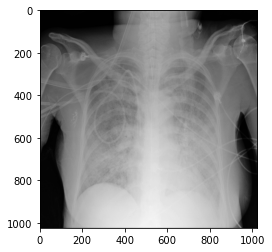

In [8]:
# read images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
i=54756

print(df_labels['Image Index'][i])
path_to_img = os.path.join('../data', df_labels['Image Index'][i])

img=mpimg.imread(path_to_img)
print(f"Image size: {img.shape}")  # 2D
print(img.max(), img.min())  # grayscale [0.0, 1.0]
print(df_labels['Patient Age'][i])
print(df_labels['Patient Gender'][i])
print(df_labels['View Position'][i])  # only AP/PA, no lateral
# Plot an image
imgplot = plt.imshow(img, cmap='gray')

Take the label *Atelectasis* as pivot, let's build a classifier for it.

Settings:
1. Consider only PA view images.
2. Binary classification.

In [9]:
disease = 'Atelectasis'

<AxesSubplot:>

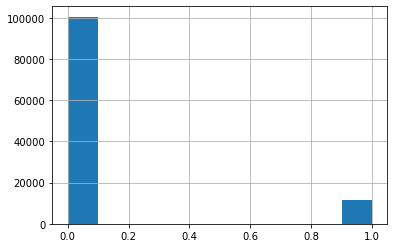

In [10]:
# Label distribution
df_labels.describe(include='all')
df_labels[disease].hist()

In [11]:
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(df_train_val, test_size=0.2,random_state=seed)  # 20% val set, about same size as test

assert len(df_train) + len(df_val) == len(df_train_val)

# Prepare train/val and test data
def select_images(df):
    df = df[df['View Position']=='PA'].reset_index()
    return df

df_train_pa = select_images(df_train)
df_val_pa = select_images(df_val)
df_test_pa = select_images(df_test)

print(f"# train images: {df_train_pa.shape[0]}")
print(f"# val images: {df_val_pa.shape[0]}")
print(f"# test images: {df_test_pa.shape[0]}")

# train images: 44954
# val images: 11260
# test images: 11096


In [12]:
df_train_pa.loc[90]

index                                     43044
Image Index                    00011114_000.png
Finding Labels                       No Finding
Follow-up #                                   0
Patient ID                                11114
Patient Age                                  19
Patient Gender                                F
View Position                                PA
OriginalImage[Width                        2544
Height]                                    3056
OriginalImagePixelSpacing[x               0.139
y]                                        0.139
Atelectasis                                   0
Cardiomegaly                                  0
Consolidation                                 0
Edema                                         0
Effusion                                      0
Emphysema                                     0
Fibrosis                                      0
Hernia                                        0
Infiltration                            

**Warning: The validation images serve as test set. Do NOT use them for model tuning.**
Use leave-out set/CV on training images for tuning instead.

Now we have the images and labels. We can train our model.

In [13]:
# Loader

class NihDataset(Dataset):
    def __init__(self, dataframe, root_dir, label, transform=None):
        """
        label: column name of the label of interest, e.g. 'Pleural Effusion'.
        """
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.label = label
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.loc[idx, 'Image Index'])
        image = Image.open(img_name).convert('L')  # via .getband(), some images are know to have 4 channels. Here we convert them to 1-channel grayscale.
        target = self.dataframe.loc[idx, disease]
            
        if self.transform:
            image = self.transform(image)
        
        return image, target
        

In [14]:
# Data loaders to return batch of images
def load_data(dataframe, root_dir, label, transform=None, batch_size=32, shuffle=True, num_workers=4):
    '''
    Data Loader with batch loading and transform.
    '''
    image_data = NihDataset(dataframe, root_dir, label, transform=transform)
    pin = device=='cpu'
    loader = torch.utils.data.DataLoader(image_data, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, pin_memory=pin)
    return loader

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop((224,224)),
        transforms.RandomHorizontalFlip(),  # data augmentation
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

Define our CNN architecture:

In [15]:
# Helper function
def conv_output_volume(W, F, S, P):
    
    """
    Given the input volume size $W$, the kernel/filter size $F$, 
    the stride $S$, and the amount of zero padding $P$ used on the border, 
    calculate the output volume size.
    """
    return int((W - F + 2*P) / S) + 1

def maxpool_output_volume(W, F, S):
    
    """
    Given the input volume size $W$, the kernel/filter size $F$, 
    the stride $S$, and the amount of zero padding $P$ used on the border, 
    calculate the output volume size.
    """
    return int(np.ceil((W - F + 1) / S))

conv_layer1_size = conv_output_volume(W=224, F=5, S=1, P=0)
maxpool_layer1_size = maxpool_output_volume(W=conv_layer1_size, F=2, S=2)

conv_layer2_size = conv_output_volume(W=maxpool_layer1_size, F=5, S=1, P=0)
maxpool_layer2_size = maxpool_output_volume(W=conv_layer2_size, F=2, S=2)

print(conv_layer1_size, maxpool_layer1_size, conv_layer2_size, maxpool_layer2_size)

220 110 106 53


In [31]:
# For now, just use a simple one from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html, plus dropout

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5)  # stride=1, padding=0
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(3, 8, 5)
        self.fc1 = nn.Linear(8 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)  # 2 classes
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # size: (batch_size*)3channels*110*110
        x = self.pool(F.relu(self.conv2(x)))  # size: (batch_size*)8channels*53*53
        x = x.view(-1, 8 * 53 * 53)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

model = Net().to(device)

In [32]:
# Define loss function and optimizer

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [33]:
# Train

import time

num_epochs = 3
batch_size = 1024

train_data_loader = load_data(df_train_pa, DATA_FOLDER, disease, transform=data_transforms['train'], shuffle=True, batch_size=batch_size)
val_data_loader = load_data(df_val_pa, DATA_FOLDER, disease, transform=data_transforms['test'], shuffle=False, batch_size=batch_size)

print(f"Training start. Mode: {device}")
start_time = time.time()

train_losses, val_losses = [], []

for epoch in range(num_epochs):  # loop over the dataset multiple times
    model.train()
    print(f"Epoch {epoch+1}")
    
    running_loss = 0.0
    for i, data in enumerate(train_data_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        # cast label data type to int
        labels = labels.type(torch.LongTensor).to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / (i+1)))
            print(f"Average time per batch: {(time.time()-start_time)/(i+1)} secs")
            #running_loss = 0.0
    else:
        # validation
        val_loss = 0
        accuracy = 0
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in val_data_loader:
                log_ps = model(images)
                val_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        train_losses.append(running_loss/len(train_data_loader))
        val_losses.append(val_loss/len(val_data_loader))

        print("Epoch: {}/{}.. ".format(epoch+1, num_epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Validation Loss: {:.3f}.. ".format(val_losses[-1]),
              "Validation Accuracy: {:.3f}".format(accuracy/len(val_data_loader)))
        
print(f'Finished Training. Total time: {time.time()-start_time} secs.')

# save state
MODEL_PATH = f'../models/simple_net_{num_epochs}epoch.pth'
torch.save(model.state_dict(), MODEL_PATH)
print("model saved")

Training start. Mode: cpu
Epoch 1
[1,    10] loss: 0.740
Average time per batch: 4.342210292816162 secs
[1,    20] loss: 0.740
Average time per batch: 3.8224127650260926 secs
[1,    30] loss: 0.740
Average time per batch: 3.657728346188863 secs
[1,    40] loss: 0.740
Average time per batch: 3.5965308487415313 secs
[1,    50] loss: 0.740
Average time per batch: 3.5364331579208375 secs
[1,    60] loss: 0.740
Average time per batch: 3.496395476659139 secs
[1,    70] loss: 0.740
Average time per batch: 3.466125934464591 secs
[1,    80] loss: 0.740
Average time per batch: 3.4367258459329606 secs
Epoch: 1/10..  Training Loss: 0.740..  Validation Loss: 0.737..  Validation Accuracy: 0.081
Epoch 2
[2,    10] loss: 0.741
Average time per batch: 40.382356595993045 secs
[2,    20] loss: 0.740
Average time per batch: 21.909858679771425 secs
[2,    30] loss: 0.741
Average time per batch: 15.723380963007608 secs
[2,    40] loss: 0.740
Average time per batch: 12.612823957204819 secs
[2,    50] loss: 0

KeyboardInterrupt: 

In [ ]:
# Load the saved model
#net = Net().to(device)
#net.load_state_dict(torch.load(MODEL_PATH))

In [ ]:
def eval_model(model, dataloader):
    """
    :return:
        Y_pred: prediction of model on the dataloder.
            Should be an 2D numpy float array where the second dimension has length 2.
        Y_test: truth labels. Should be an numpy array of ints
    """
    model.eval()
    Y_prob = []
    Y_pred = []
    Y_test = []
    for data, target in dataloader:
        outputs = model(data.to(device))
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)
        Y_prob.append(probs)
        Y_pred.append(predicted)
        Y_test.append(target)
        
    Y_prob = np.concatenate(Y_prob, axis=0)
    Y_pred = np.concatenate(Y_pred, axis=0)
    Y_test = np.concatenate(Y_test, axis=0)

    return Y_prob, Y_pred, Y_test


from sklearn.metrics import accuracy_score, roc_auc_score

# lower batch size if out of memory
test_data_loader = load_data(df_test_pa, DATA_FOLDER, disease, transform=data_transforms['test'], shuffle=False, batch_size=256, num_workers=7)

y_prob, y_pred, y_true = eval_model(net, test_data_loader)
acc = accuracy_score(y_true, y_pred)
roc = roc_auc_score(y_true, y_prob)
print(("Test Accuracy: " + str(acc)))
print(("Test ROC: " + str(roc)))